# Logistic Regression
Notebook producing the figures in "[Linear Regression to Neural Networks](https://dunnkers.com/linear-regression-to-neural-networks)". Chapter on **Logistic Regression**. We are going to fit a Logistic Regression model to try and classify some Penguin species data. We are going to produce this plot:
    
![logistic fit](../images/logistic-fit.gif)

Let's go!

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
from IPython.display import HTML
import IPython
from matplotlib.animation import FuncAnimation
from time import time
from tqdm.notebook import tqdm
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss
import tempfile
import shutil
%matplotlib inline
set_matplotlib_formats('svg')
!python --version

Python 3.9.2


In [2]:
from sklearn.exceptions import ConvergenceWarning
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [3]:
data = sns.load_dataset('penguins')
data = data.dropna()
data.dtypes

species               object
island                object
bill_length_mm       float64
bill_depth_mm        float64
flipper_length_mm    float64
body_mass_g          float64
sex                   object
dtype: object

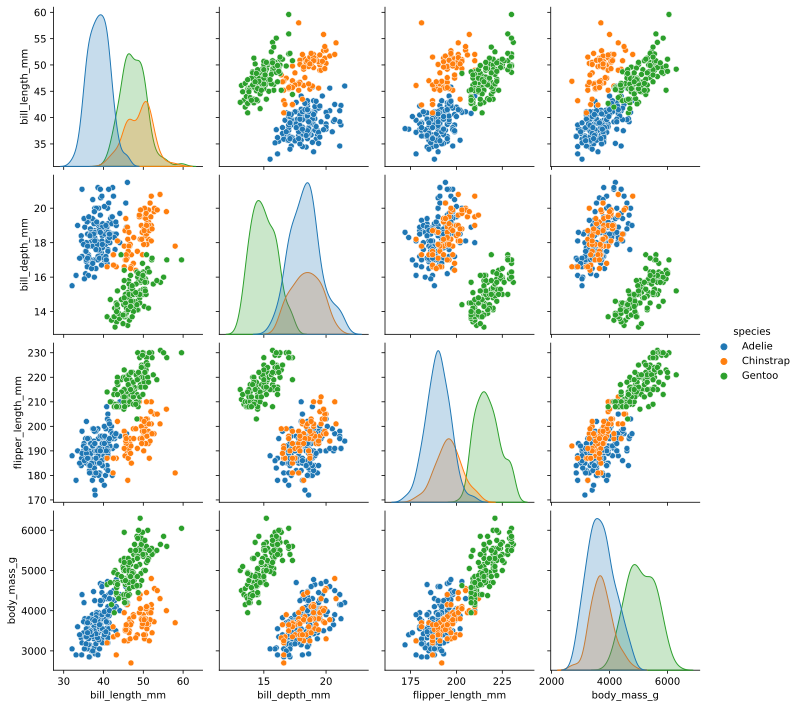

In [4]:
sns.pairplot(data=data, hue='species')

In [5]:
peng = lambda x: 'Chinstrap' if x == 'Chinstrap' else 'Other'
data['Penguin'] = data['species'].apply(peng)

In [6]:
rs = np.random.RandomState(34)
test = rs.choice(data.index, len(data) // 4)
train = data.index[~data.index.isin(test)]
data.loc[train, 'subset'] = 'Train'
data.loc[test, 'subset'] = 'Test'
data_train = data[data['subset'] == 'Train']
data_test = data[data['subset'] == 'Test']
data.groupby('subset').count()[['species']]

,species
subset,
Test,78
Train,255


<AxesSubplot:xlabel='bill_depth_mm', ylabel='bill_length_mm'>

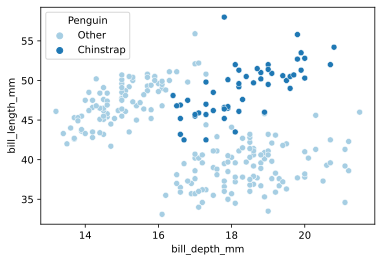

In [7]:
blue_colors = sns.color_palette("Paired", n_colors=2)
sns.scatterplot(data=data_train, x='bill_depth_mm', y='bill_length_mm',
                hue='Penguin', palette=blue_colors)

In [8]:
clf = SGDClassifier(max_iter=50, tol=None, loss='log', alpha=0.0,
                    learning_rate='constant', eta0=0.001, random_state=33,
                    verbose=0, warm_start=True)

X = data_train[['bill_depth_mm', 'bill_length_mm']].values
y, labels = pd.factorize(data_train['Penguin'])
Y = np.expand_dims(y, axis=1)

X_test = data_test[['bill_depth_mm', 'bill_length_mm']].values
y_test, _ = pd.factorize(data_test['Penguin'])
Y_test = np.expand_dims(y_test, axis=1)

clf.fit(X, y)
classes = clf.classes_
clf.coef_, clf.intercept_, clf.n_iter_, clf.classes_

(array([[-0.11750903,  0.05547049]]), array([-0.24530203]), 50, array([0, 1]))

In [9]:
clf.fit(X, y)
clf.n_iter_, clf.coef_, clf.t_

(50, array([[-0.11041536,  0.05812061]]), 12751.0)

In [10]:
def combine_coefs(clf):
    coef = np.append(clf.intercept_, clf.coef_)
    coef = np.expand_dims(coef, axis=0).T
    return coef
combine_coefs(clf)

array([[-0.48528539],
       [-0.11041536],
       [ 0.05812061]])

In [11]:
decision_function = lambda X, coef: X @ coef
predict_proba_lr = lambda X, coef: 1. / (1. + np.exp(-decision_function(X, coef)))
predict_proba_lr([[1, 2, 3]], combine_coefs(clf))

array([[0.37010783]])

In [12]:
def add_bias(X):
    n, p = X.shape
    bias = np.ones((n, 1))
    X = np.hstack([bias, X])
    return X
X.shape, add_bias(X).shape

((255, 2), (255, 3))

In [13]:
def get_losses(coef):
    pred = predict_proba_lr(add_bias(X), coef)
    loss = log_loss(y, pred)
    
    pred_test = predict_proba_lr(add_bias(X_test), coef)
    loss_test = log_loss(y_test, pred_test)
    return [loss, loss_test]
get_losses(combine_coefs(clf))

[0.7374884266002778, 0.7569569316061243]

In [14]:
def get_acc(pred, Y):
    class_pred = np.array(pred > 0.5).astype(int)
    acc = (class_pred == Y).sum() / len(Y)
    return acc

def get_accs(coef):
    pred = predict_proba_lr(add_bias(X), coef)
    pred_test = predict_proba_lr(add_bias(X_test), coef)
    return get_acc(pred, Y), get_acc(pred_test, Y_test)
get_accs(combine_coefs(clf))

(0.6196078431372549, 0.6538461538461539)

In [15]:
max_iter = 50
iterations = 30000
n_fits = iterations // max_iter
clf = SGDClassifier(max_iter=max_iter, tol=None, loss='log', alpha=0.0,
                    learning_rate='constant', eta0=0.001, random_state=33,
                    verbose=0, warm_start=True)

history = np.array([])
pbar = tqdm(range(n_fits))
for i in pbar:
    clf.fit(X, y)
    
    coef = combine_coefs(clf)
    loss = get_losses(coef)
    acc = get_accs(coef)
    history = np.append(history, {
        'coef': combine_coefs(clf),
        'loss': get_losses(coef),
        'acc': get_accs(coef),
        'iteration': (i + 1) * clf.n_iter_
    })

  0%|          | 0/600 [00:00<?, ?it/s]

In [16]:
coefs = [hist['coef'] for hist in history]
losses = [hist['loss'] for hist in history]
accs = [hist['acc'] for hist in history]
iters = [hist['iteration'] for hist in history]

In [17]:
df = pd.DataFrame(losses, columns=['Train', 'Test'])
df['iteration'] = iters
df = df.melt(id_vars='iteration', value_name='Loss', var_name='Subset')
df

,iteration,Subset,Loss
0,50,Train,0.742088
1,100,Train,0.737488
2,150,Train,0.732837
3,200,Train,0.728134
4,250,Train,0.723380
...,...,...,...
1195,29800,Test,0.294282
1196,29850,Test,0.294301
1197,29900,Test,0.294320
1198,29950,Test,0.294339


<AxesSubplot:xlabel='iteration', ylabel='Loss'>

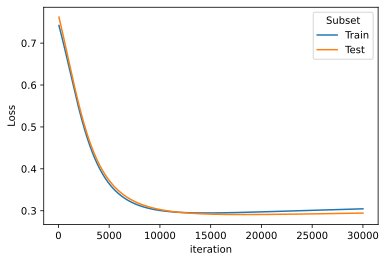

In [18]:
sns.lineplot(data=df, x='iteration', y='Loss', hue='Subset')

In [19]:
def apply_over_grid(X, clf, *args):
    xaxis = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    yaxis = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
    xx, yy = np.meshgrid(xaxis, yaxis)
    zz = np.dstack([xx, yy])
    ax1, ax2, ax3 = zz.shape
    X = zz.reshape((ax1 * ax2, ax3))
    zz = clf(X, *args)
    zz = zz.reshape((ax1, ax2))
    return xx, yy, zz

xx, yy, zz = apply_over_grid(X, lambda X: X.sum(axis=1))
X.shape, xx.shape, yy.shape, zz.shape

((255, 2), (100, 100), (100, 100), (100, 100))

'loss=[0.30451492493719545, 0.2943587554212418], acc=(0.8823529411764706, 0.8974358974358975)'

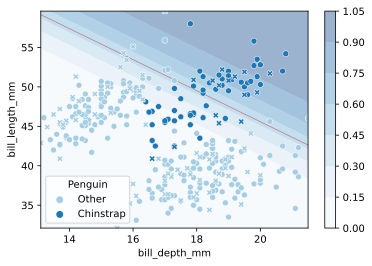

In [20]:
def decision_region(coef, ax):
    predictor = lambda X, coef: predict_proba_lr(add_bias(X), coef)
    vals = data[['bill_depth_mm', 'bill_length_mm']].values
    xx, yy, zz = apply_over_grid(vals, predictor, coef)
    plt.contourf(xx, yy, zz, alpha=0.7,
                           levels=[0.495, 0.505], colors=['red'])
    plt.contourf(xx, yy, zz, alpha=0.4, cmap='Blues')
    sns.scatterplot(data=data_train,
                    x='bill_depth_mm', y='bill_length_mm',
                    hue='Penguin', palette=blue_colors, ax=ax)
    sns.scatterplot(data=data_test,
                    x='bill_depth_mm', y='bill_length_mm',
                    hue='Penguin', palette=blue_colors, ax=ax,
                    legend=False,
                    style='subset', style_order=['Train', 'Test'])
    
fig = plt.figure()
ax = fig.gca()
decision_region(coefs[-1], ax)
plt.colorbar()
f"loss={losses[-1]}, acc={accs[-1]}"

In [21]:
folder = tempfile.mkdtemp()
print(f'Saving images to {folder}')

Saving images to /var/folders/34/923qqr696yz_ybx0dl171fn80000gn/T/tmppulnoy6i


  0%|          | 0/200 [00:00<?, ?it/s]

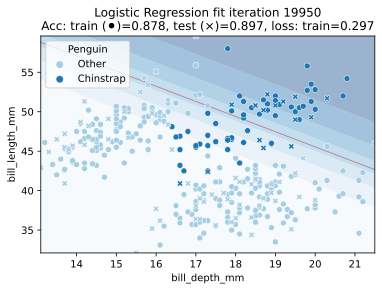

In [22]:
import time

frames = 200
iter_right_lim = 20000
n_fits_show = iter_right_lim // max_iter
intervals = n_fits_show // frames
pbar = tqdm(total=frames)
def create_frame(frame, ax, coefs):
    ax.cla()
    i = frame * intervals
    coef = coefs[i]
    loss = losses[i][0]
    loss_test = losses[i][1]
    acc = accs[i][0]
    acc_test = accs[i][1]
    iteration = iters[i]
    
    decision_region(coef, ax)

    plt.title(f'Logistic Regression fit iteration {iteration}\n'+
              f'Acc: train (⚫︎)={acc:.3f}, test (×)={acc_test:.3f}, '+
              f'loss: train={loss:.3f}')
    pbar.update()
    plt.savefig(f'{folder}/frame_{frame:03}.png')
    
fig = plt.figure()
ax = fig.gca()
animation = FuncAnimation(fig, create_frame, frames=frames,
                          fargs=(ax, coefs), interval=100)
                # Interval at 1000/100 = 10 frames per second
animated = animation.to_jshtml()
pbar.close()

In [23]:
!convert -background white -alpha remove -dispose Previous +antialias -layers OptimizePlus $folder/*.png ../images/logistic-fit.gif

In [24]:
shutil.rmtree(folder)